### References

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [104]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

### Aux functions acquired from the pratical classes




In [105]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()

def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    


def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()    



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    

In [106]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', 
                                    min_delta = 0.0001, #minimum delta to count as getting better
                                    patience = 5, #number of rounds to wait for the monitor to get better
                                    verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]
    

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

In here we go to 64 to achieve faster training epochs (rather than 32)

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/



In [107]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

### Paths to images


In [108]:
TRAIN_IMAGES_PATH = './Images/Train/'
TEST_IMAGES_PATH = './Images/Test/'

### Prepare to load images

In [109]:
data_dir = pathlib.Path(TRAIN_IMAGES_PATH)
  
classNames = np.array(os.listdir(data_dir))
classNames


array(['00026', '00027', '00033', '00038', '00016', '00020', '00040',
       '00021', '00009', '00005', '00041', '00010', '00025', '00032',
       '00001', '00007', '00022', '00039', '00000', '00014', '00011',
       '00031', '00036', '00042', '00019', '00015', '00018', '00002',
       '00023', '00008', '00037', '00035', '00028', '00017', '00034',
       '00003', '00024', '00030', '00013', '00006', '00004', '00012',
       '00029'], dtype='<U5')

### Converting PPM to PNG

In [110]:

  
from PIL import Image
import os
import glob
import string

for filepath in glob.iglob("**/*.ppm*", recursive=True):
        im = Image.open(filepath)
        filepath2=filepath[:-4]
        filepath2= filepath2+".png"
    
        
        im.save(filepath2)
        os.remove(filepath)

### Loading images takes place in here

In [111]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(TRAIN_IMAGES_PATH + "*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



### Information about image shape and size of training set

In [112]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", dataset_length)  

(32, 32, 3) (43,)
Total images in dataset:  39209


# Version I - training with dataset only

### Preparing training, validation and test datasets

In [113]:

dataSolo = dataset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.shuffle(buffer_size = dataset_length)
dataSolo = dataSolo.prefetch(buffer_size=dataset_length)
dataSolo = dataSolo.batch(batch_size=BATCH_SIZE)
dataSolo = dataSolo.repeat()

In [114]:
train_size = int(0.8* dataset_length)
val_size = int(0.2* dataset_length)

train_dataset = dataSolo.take(train_size)
train_dataset = train_dataset.repeat()
val_dataset = dataSolo.skip(train_size)


In [115]:
test_listset = tf.data.Dataset.list_files(TEST_IMAGES_PATH + "*/*.png")
test_dataset_length = test_listset.cardinality().numpy()
print("Total images in validatation dataset: ", test_dataset_length)

testset = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size = BATCH_SIZE)


Total images in validatation dataset:  12630


### Show a batch of training images

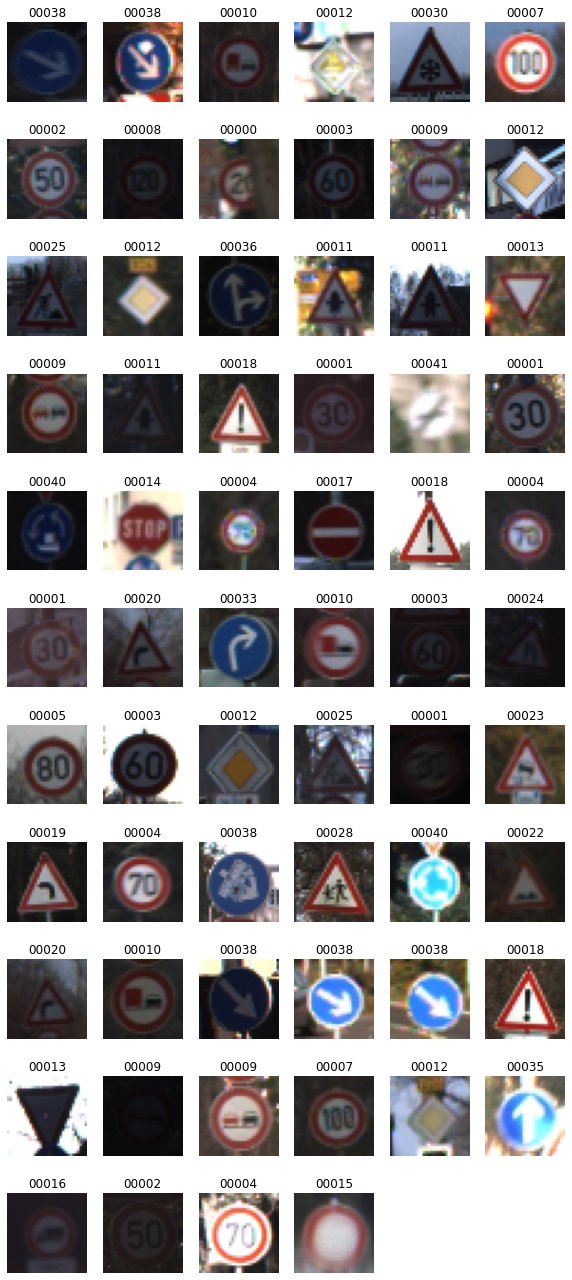

In [97]:
image_batch, label_batch = next(iter(train_dataset))        
show_batch(image_batch, label_batch.numpy())

### Show a batch of validation images

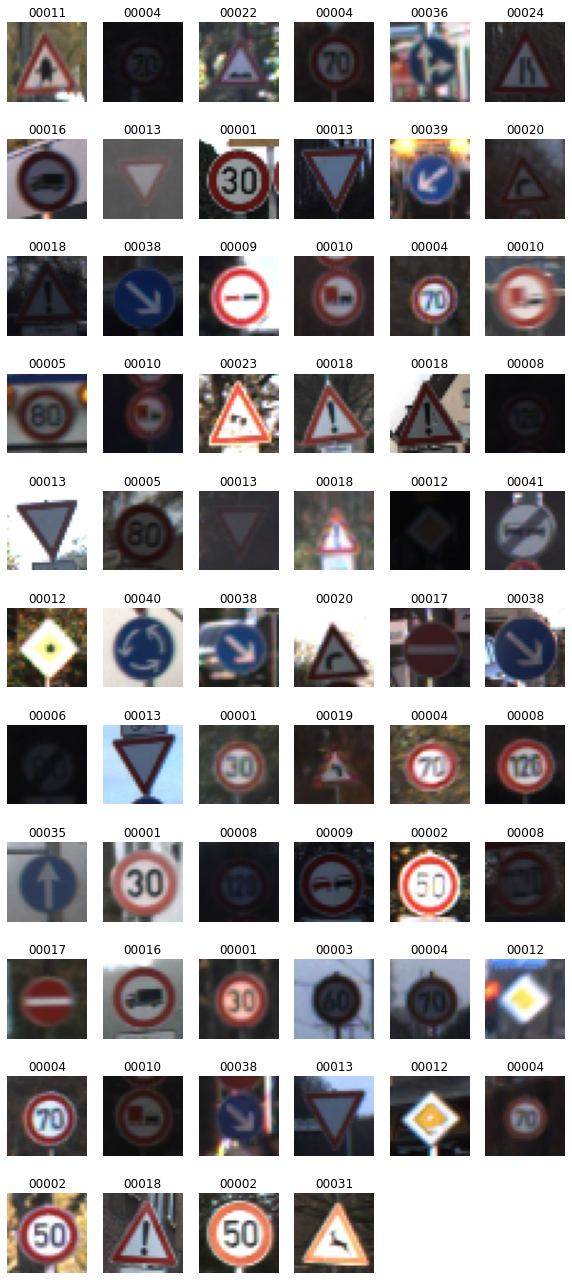

In [98]:
image_batch, label_batch = next(iter(val_dataset))        
show_batch(image_batch, label_batch.numpy())

### Build a CNN network

In [116]:
def model_VI(classCount, imgSize, channels):

    model = Sequential()
    
    model.add(Conv2D(128, (5, 5),
                     input_shape=(imgSize, imgSize, channels)))         
    model.add(LeakyReLU(alpha=0.01))  
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 

    model.add(Conv2D(196, (5, 5) )) 
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 

    model.add(Conv2D(256, (5, 5) ) )   
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    
    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.0)) 
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.0))             
    model.add(Dropout(0.5)) 
    
    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model


In [117]:
modelV1 = model_VI(43, 32, 3)

print(modelV1.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 128)       9728      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 28, 28, 128)       0         
                                                                 
 batch_normalization_21 (Bat  (None, 28, 28, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 28, 28, 128)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 196)       627396    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 24, 24, 196)       0         
                                                      

### Train the network 

In [121]:
file_pathV1 = './Networks/JustDataset.ckpt'

callbacksV1 = prepare_callbacks(file_pathV1)

historyV1 = modelV1.fit(train_dataset, steps_per_epoch = 32,
          epochs=20, 
          validation_data = val_dataset,
          validation_steps = 0.2*val_size/BATCH_SIZE,
          callbacks = callbacksV1)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 3.0881 - accuracy: 0.2197
Epoch 1: val_accuracy improved from -inf to 0.05375, saving model to ./Networks/JustDataset.ckpt
32/32 [==============================] - 99s 3s/step - loss: 3.0881 - accuracy: 0.2197 - val_loss: 3.5963 - val_accuracy: 0.0538 - lr: 1.0000e-04
Epoch 2/20
20/32 [=================>............] - ETA: 30s - loss: 2.9086 - accuracy: 0.2313

KeyboardInterrupt: 

### Plot the training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


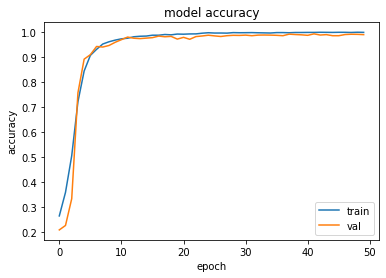

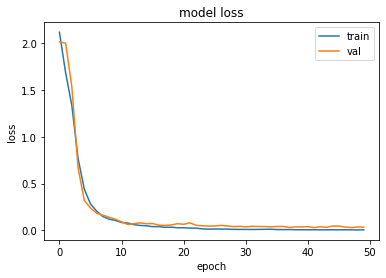

In [15]:
show_history(historyV1)

### Evaluate Model

In [16]:
modelV1.load_weights(file_pathV1)

evalV1 = modelV1.evaluate(testset, verbose=2)
valV1 = modelV1.evaluate(val_dataset, verbose=2)

66/66 - 2s - loss: 0.0454 - accuracy: 0.9892
1/1 - 0s - loss: 0.0290 - accuracy: 0.9926


# NOTHING HAS BEEN CHANGED BELOW

# Version II - dynamic data augmentation

### Function to transform image

In [17]:


#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa


def process_image(image, label):
    
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
   
    # change hue, saturation and value
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1),0,1)

    return image, label

In [18]:
dataV2 = dataset
dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = dataset_length)
dataV2 = dataV2.map(process_image)
dataV2 = dataV2.prefetch(buffer_size=10200)
dataV2 = dataV2.batch(batch_size=BATCH_SIZE)
dataV2 = dataV2.repeat()

In [19]:
modelV2 = model_VI(8, 32, 3)

file_pathV2 = 'd:/temp/DL04/DA_modelV2/cp.ckpt'

callbacksV2 = prepare_callbacks(file_pathV2)

historyV2 = modelV2.fit(dataV2, steps_per_epoch = 10200/BATCH_SIZE,
          epochs=50, 
          validation_data = valset, 
          callbacks = callbacksV2)

Epoch 1/50
159/159 [==============================] - 4s 16ms/step - loss: 2.5262 - accuracy: 0.1976 - val_loss: 2.0464 - val_accuracy: 0.1744

Epoch 00001: val_accuracy improved from -inf to 0.17442, saving model to d:/temp/DL04/DA_modelV2\cp.ckpt
Epoch 2/50
159/159 [==============================] - 3s 16ms/step - loss: 1.9235 - accuracy: 0.2563 - val_loss: 2.1138 - val_accuracy: 0.1814

Epoch 00002: val_accuracy improved from 0.17442 to 0.18140, saving model to d:/temp/DL04/DA_modelV2\cp.ckpt
Epoch 3/50
159/159 [==============================] - 3s 16ms/step - loss: 1.8489 - accuracy: 0.2675 - val_loss: 2.0553 - val_accuracy: 0.1860

Epoch 00003: val_accuracy improved from 0.18140 to 0.18605, saving model to d:/temp/DL04/DA_modelV2\cp.ckpt
Epoch 4/50
159/159 [==============================] - 3s 16ms/step - loss: 1.8033 - accuracy: 0.2897 - val_loss: 1.9574 - val_accuracy: 0.1981

Epoch 00004: val_accuracy improved from 0.18605 to 0.19806, saving model to d:/temp/DL04/DA_modelV2\cp.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


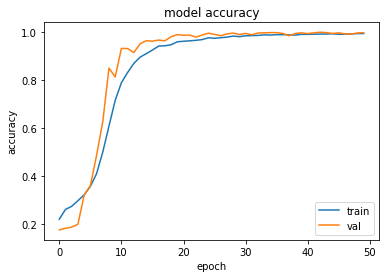

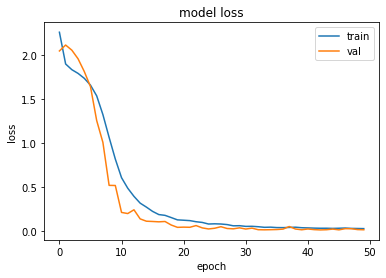

66/66 - 1s - loss: 0.0358 - accuracy: 0.9894
1/1 - 0s - loss: 0.0090 - accuracy: 0.9984


In [20]:
show_history(historyV2)

modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(testset, verbose=2)
valV2 = modelV2.evaluate(valset, verbose=2)

# Version III - Massive data augmentation

### Data augmentation functions

In [21]:
import tensorflow_addons as tfa

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

In [22]:
dataV3 = dataset
# color ops
dataV3 = dataV3.map(process_brightness)
dataV3 = dataV3.concatenate(dataset.map(process_contrast))
dataV3 = dataV3.concatenate(dataset.map(process_hue))
dataV3 = dataV3.concatenate(dataset.map(process_saturation))

#geometry ops
dataV3 = dataV3.concatenate(dataset.map(process_rotate))
dataV3 = dataV3.concatenate(dataset.map(process_shear))
dataV3 = dataV3.concatenate(dataset.map(process_translate))
dataV3 = dataV3.concatenate(dataset.map(process_crop))

dataV3 = dataV3.cache()
dataV3 = dataV3.shuffle(buffer_size = 81600)
dataV3 = dataV3.batch(batch_size = BATCH_SIZE)
dataV3 = dataV3.prefetch(buffer_size = AUTOTUNE)
dataV3 = dataV3.repeat()



In [23]:
modelV3 = model_VI(8, 32, 3)

file_pathV3 = 'd:/temp/DL04/DA_modelV3/cp.ckpt'

callbacksV3 = prepare_callbacks(file_pathV3)

historyV3 = modelV3.fit(dataV3, steps_per_epoch = 81600/BATCH_SIZE,
          epochs=50, 
          validation_data = valset, 
          callbacks = callbacksV3)

Epoch 1/50
1275/1275 [==============================] - 33s 15ms/step - loss: 1.8070 - accuracy: 0.3538 - val_loss: 0.1992 - val_accuracy: 0.9438

Epoch 00001: val_accuracy improved from -inf to 0.94380, saving model to d:/temp/DL04/DA_modelV3\cp.ckpt
Epoch 2/50
1275/1275 [==============================] - 19s 15ms/step - loss: 0.3793 - accuracy: 0.8750 - val_loss: 0.0597 - val_accuracy: 0.9802

Epoch 00002: val_accuracy improved from 0.94380 to 0.98023, saving model to d:/temp/DL04/DA_modelV3\cp.ckpt
Epoch 3/50
1275/1275 [==============================] - 19s 15ms/step - loss: 0.1802 - accuracy: 0.9416 - val_loss: 0.0399 - val_accuracy: 0.9857

Epoch 00003: val_accuracy improved from 0.98023 to 0.98566, saving model to d:/temp/DL04/DA_modelV3\cp.ckpt
Epoch 4/50
1275/1275 [==============================] - 19s 15ms/step - loss: 0.1092 - accuracy: 0.9633 - val_loss: 0.0329 - val_accuracy: 0.9922

Epoch 00004: val_accuracy improved from 0.98566 to 0.99225, saving model to d:/temp/DL04/DA

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


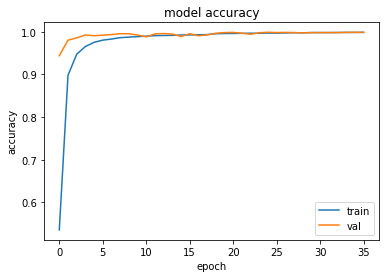

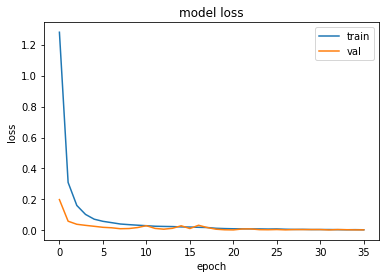

66/66 - 2s - loss: 0.0339 - accuracy: 0.9926
1/1 - 0s - loss: 0.0046 - accuracy: 0.9988


In [24]:
show_history(historyV3)

modelV3.load_weights(file_pathV3)

evalV3 = modelV3.evaluate(testset, verbose=2)
valV3 = modelV3.evaluate(valset, verbose=2)

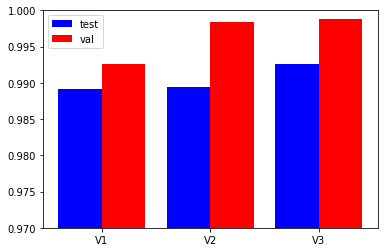

In [25]:


show_accuracies(['V1', 'V2', 'V3'], [evalV1[1], evalV2[1], evalV3[1]], [valV1[1], valV2[1], valV3[1]])

27


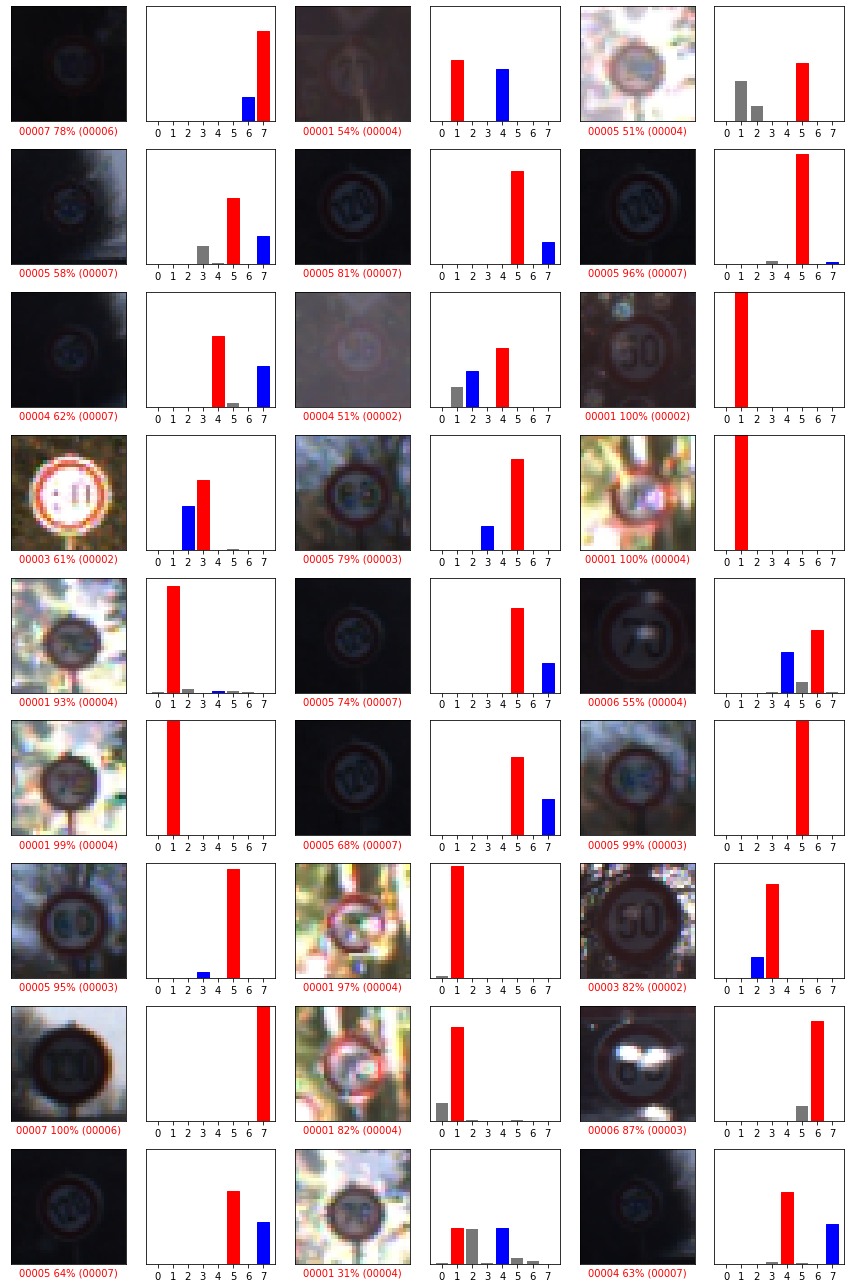

In [26]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV3.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((4170 - 4170*.994)/3 + 1))

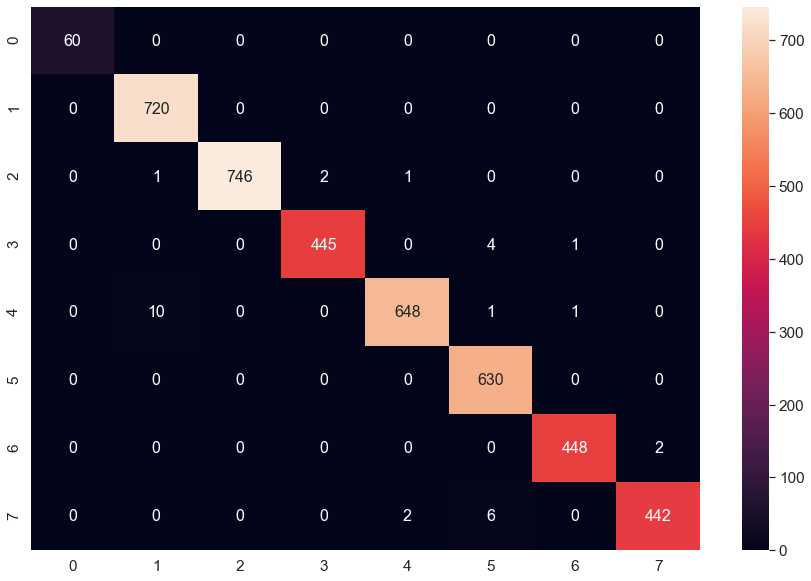

In [27]:
all_labels = [np.argmax(x) for x in numpy_labels]
all_preds = [np.argmax(x) for x in pred]
    
conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

show_confusion_matrix(conf_mat.numpy(), 8)

